In [2]:
import sys
assert sys.version_info >= (3,7)

In [3]:
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size = 14)
plt.rc("axes", labelsize = 14, titlesize = 14)
plt.rc("legend", fontsize = 14)
plt.rc("xtick", labelsize = 10)
plt.rc("ytick", labelsize = 10)

### Linear Regression

#### The Normal Equation

In [5]:
import numpy as np

np.random.seed(42)
m = 100
X = 2 * np.random.rand(m , 1)
y = 4 + 3 * X + np.random.rand(m, 1)


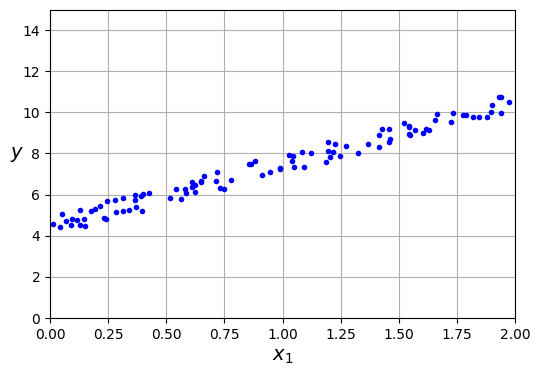

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation = 0)
plt.grid()
plt.axis([0,2,0,15])

plt.show()

In [7]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
theta_best

array([[4.51359766],
       [2.98323418]])

In [8]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)
y_predict = X_new_b @ theta_best
y_predict

array([[ 4.51359766],
       [10.48006601]])

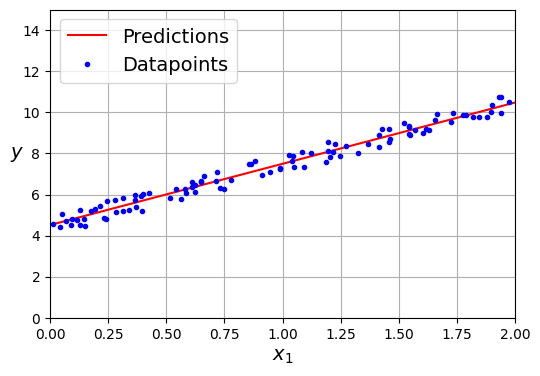

In [9]:
plt.figure(figsize=(6,4))
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X,y, "b.", label = "Datapoints")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation = 0)
plt.grid()
plt.axis([0,2,0,15])
plt.legend(loc="upper left")

plt.show()

In [10]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.51359766]), array([[2.98323418]]))

In [11]:
lin_reg.predict(X_new)

array([[ 4.51359766],
       [10.48006601]])

In [12]:
eta = 0.1
n_epochs = 1000
m = len(X_b)

np.random.seed(42)
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    gradients = 2/ m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

theta


array([[4.51359766],
       [2.98323418]])

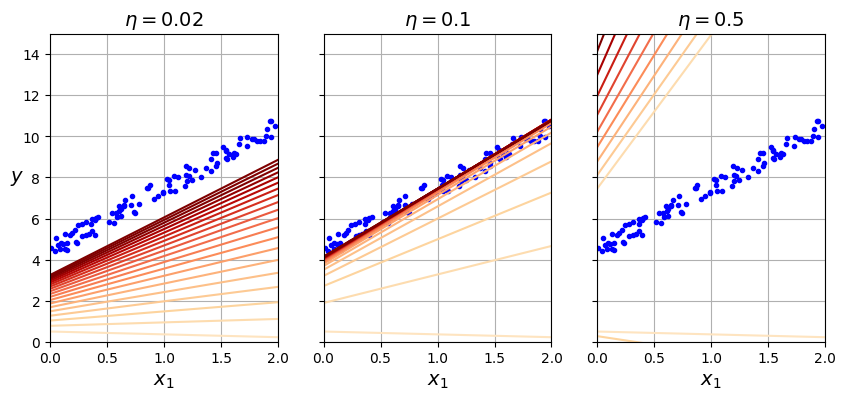

In [13]:
import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []

    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15) )
            plt.plot(X_new, y_predict, linestyle="solid", color = color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)

    plt.xlabel("$x_1$")
    plt.axis([0,2,0,15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")

    return theta_path
            

np.random.seed(42)
theta = np.random.randn(2,1)

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation = 0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta = 0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta = 0.5)
plt.show()

#### Stochastic Gradient Descent using a simple learning schedule

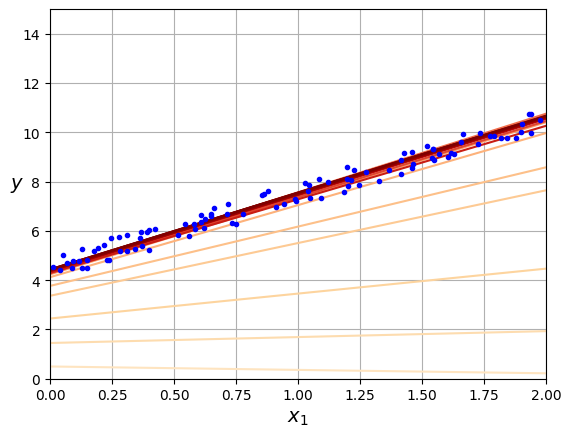

In [18]:
n_epochs = 50
t0, t1 = 5, 50
n_shown = 20
theta_path_sgd = []

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for iteration in range(m):

        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color = color)

        random_index = np.random.randint(m)
        xi = X_b[random_index: random_index + 1]
        yi = y[random_index: random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation = 0)
plt.axis([0,2,0, 15])
plt.grid()
plt.show()

In [15]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X,y.ravel())

,loss,'squared_error'
,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,1e-05
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,42


In [16]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.50316965]), array([2.99156535]))

#### Mini Batch Gradient Descent

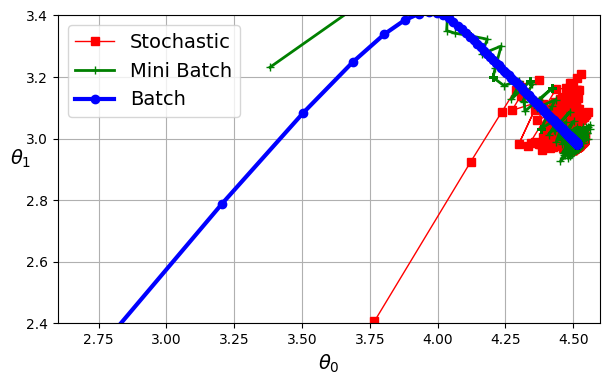

In [24]:
from math import ceil

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
theta = np.random.randn(2,1)

t0, t1 = 200, 1000

def learning_schedule(t):
    return t0 / (t + t1)

theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]

    for iteration in range(n_epochs):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]
        yi = y_shuffled[idx: idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch * n_batches_per_epoch + iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize = (7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth = 1,
         label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:,1], "g-+", linewidth=2,
         label="Mini Batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:,1], "b-o", linewidth=3,
         label="Batch")

plt.legend(loc="upper left")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$", rotation = 0)
plt.axis([2.6, 4.6, 2.4, 3.4])
plt.grid()

plt.show()


### Polynomial Regression

In [32]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m , 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m , 1)

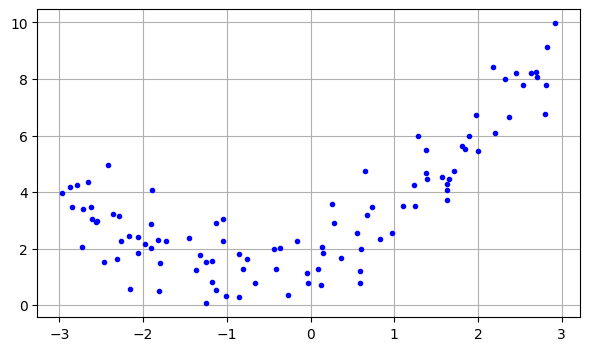

In [33]:
plt.figure(figsize=(7,4))
plt.plot(X, y, "b.")
plt.grid()

plt.show()

In [34]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([-0.75275929]), array([-0.75275929,  0.56664654]))

In [35]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_


(array([1.78134581]), array([[0.93366893, 0.56456263]]))

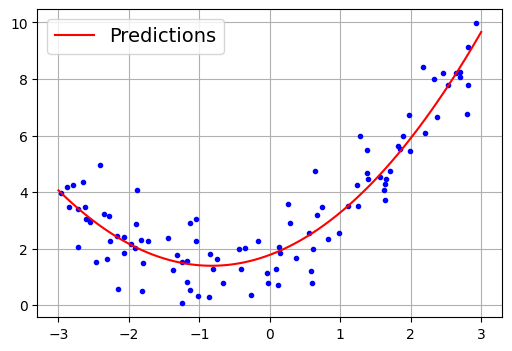

In [42]:
X_new = np.linspace(-3,3,100).reshape(100,1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6,4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", label="Predictions")
plt.grid()
plt.legend(loc="upper left")

plt.show()